In [4]:
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *

data = {
    'x1': load_data('../stats/fpm_4_2D_x1.json'),
    'x4': load_data('../stats/fpm_4_2D_x2.json'),
    'x9': load_data('../stats/fpm_4_2D_x3.json'),
    'x16': load_data('../stats/fpm_4_2D_x4.json'),
    # 'x25': load_data('../stats/fpm_4_2D_x5.json')
    # 'x64': load_data('../stats/fpm_4_2D_x8.json'),
}

In [5]:
shape = [4, 1]
figsize = (7, 6)

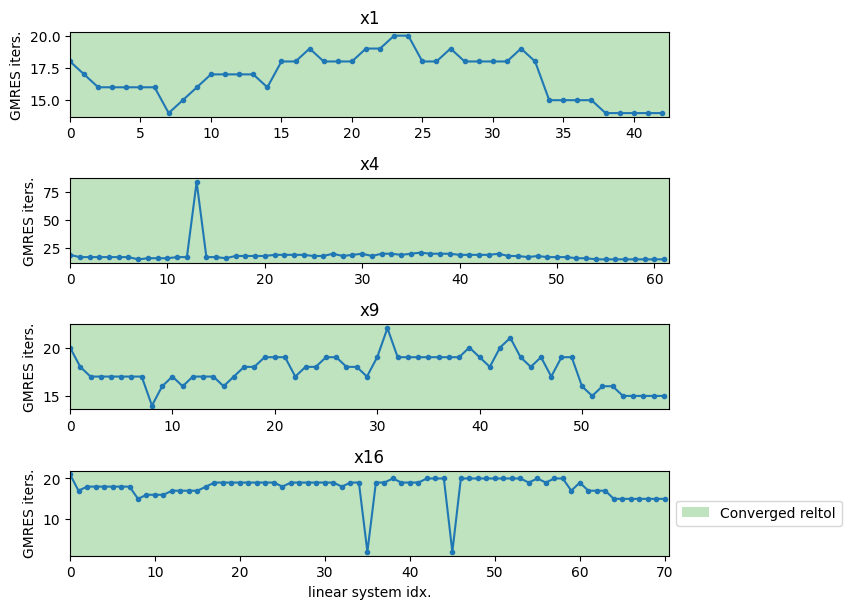

In [6]:
def render_element(entry: Sequence[TimeStepStats]):
    color_converged_reason(entry)
    # color_time_steps(entry, fill=False, legend=True)
    plt.gca().grid(False)
    plt.plot(get_gmres_iterations(entry), marker='.')

plot_grid(data, render_element, shape=shape, figsize=figsize, legend=True)

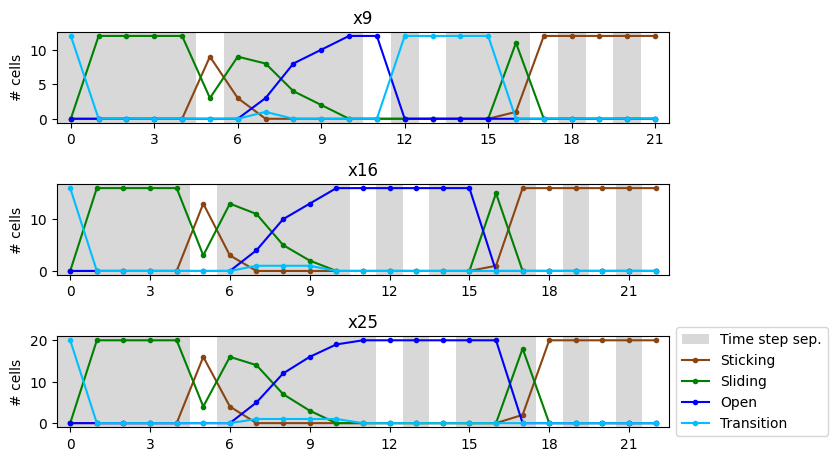

In [132]:
def render_element(entry: Sequence[TimeStepStats]):
    st, sl, op, tr = get_num_sticking_sliding_open_transition(entry)
    color_time_steps(entry, fill=True, grid=False, legend=True)
    plt.plot(st, label='Sticking', marker='.', color=COLOR_STICKING)
    plt.plot(sl, label='Sliding', marker='.', color=COLOR_SLIDING)
    plt.plot(op, label='Open', marker='.', color=COLOR_OPEN)
    plt.plot(tr, label='Transition', marker='.', color=COLOR_TRANSITION)

plot_grid(data, render_element, shape=shape, figsize=figsize, ylabel='# cells')

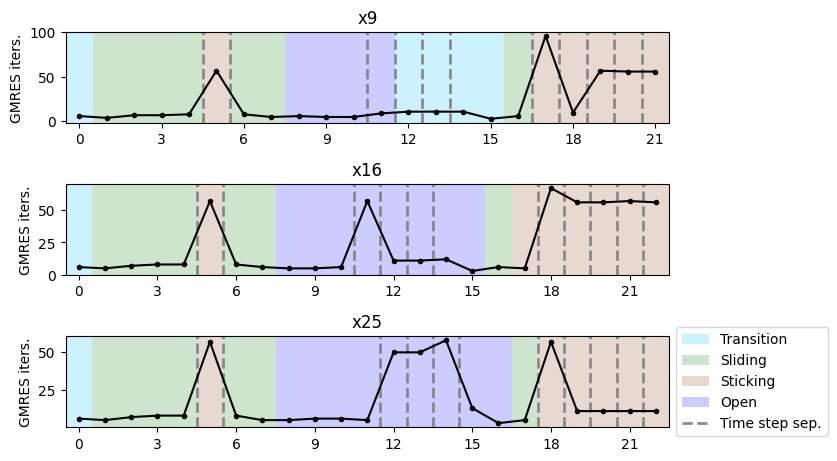

In [133]:
def render_element(entry: Sequence[TimeStepStats]):
    color_sticking_sliding_open_transition(entry)
    color_time_steps(entry, fill=False, legend=True)
    plt.gca().grid(False)
    plt.plot(get_gmres_iterations(entry), marker='.', color='black')
    # plt.ylim(top=15)

plot_grid(data, render_element, shape=shape, figsize=figsize, legend=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


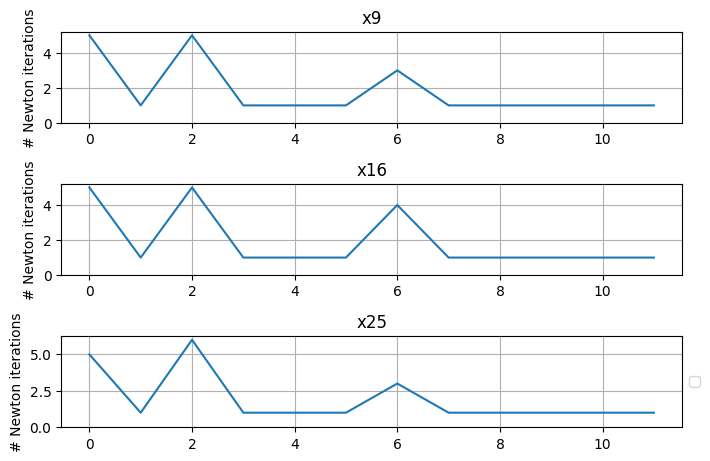

In [134]:
def render_element(entry: Sequence[TimeStepStats]):
    plt.plot(get_newton_iterations(entry))
    plt.ylim(bottom=0)
    plt.grid()

plot_grid(data, render_element, shape=shape, figsize=figsize, ylabel='# Newton iterations', xlabel='time step')

Text(0.5, 0, 'Simulation time, s')

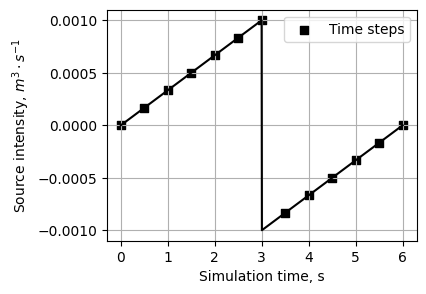

In [135]:
from fpm_4_2D import make_model

model = make_model(cell_size_multiplier=1)
model.prepare_simulation()
source = []
t_list = np.linspace(0, 6, 13, endpoint=True)
for t in t_list:
    source.append(model.get_source_intensity(t))

source_fine = []
t_list_fine = np.linspace(0, 6, 1000, endpoint=True)
for t in t_list_fine:
    source_fine.append(model.get_source_intensity(t))

plt.figure(figsize=(4, 3))
plt.plot(t_list_fine, source_fine, color='black')
plt.scatter(t_list, source, marker='s', label='Time steps', color='black')
plt.grid()
plt.legend()
plt.ylabel(r'Source intensity, $m^3 \cdot s^{-1}$')
plt.xlabel('Simulation time, s')

# Testing bad matrix

In [113]:
assert False

AssertionError: 

In [136]:
from fpm_4_2D import make_model

model = make_model(cell_size_multiplier=5)
model.prepare_simulation()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model._initialize_solver()



num sticking: 0
num sliding: 0
num open: 0
num transition: 20


In [137]:
mat_idx = 13
entry = data['x25']
print(get_gmres_iterations(entry)[mat_idx])
mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(entry, mat_idx)

50


In [138]:
model.linear_system = mat, rhs
model.equation_system.set_variable_values(iterate, iterate_index=0)
model.equation_system.set_variable_values(state, time_step_index=0)  # 1

model.ad_time_step.set_value(dt)
st, sl, op, tr = model.sticking_sliding_open_transition()
print(sum(st))
print(sum(sl))
print(sum(op))
print(sum(tr))

model.assemble_linear_system()
perm_mat, prec_orig = model._prepare_solver()
J = perm_mat[:]

0
0
20
0


Solve  took: 1.1
True residual decrease: 3.1430474547885345
PETSc Converged Reason: -5
lambda min: 0.1340555702656717


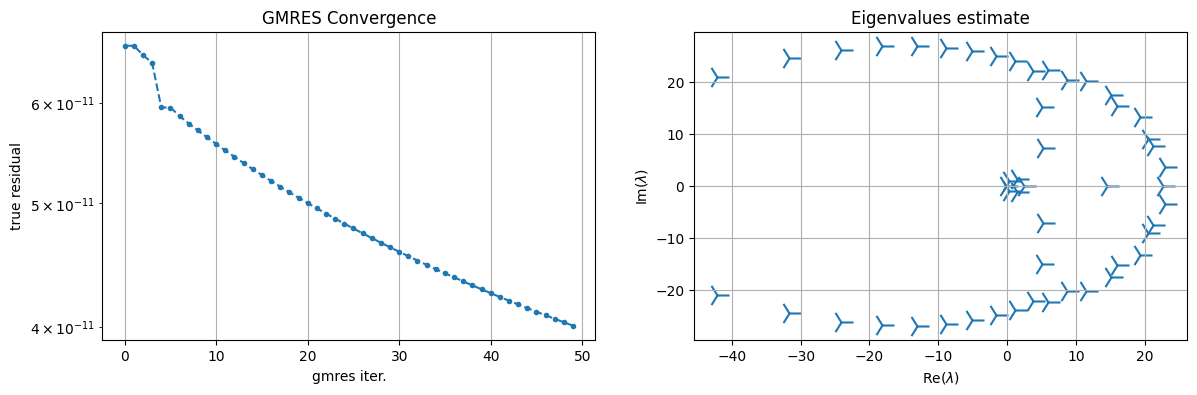

In [139]:
solve_petsc(perm_mat.mat, prec_orig, rhs=model.rhs_Q, pc_side='right')

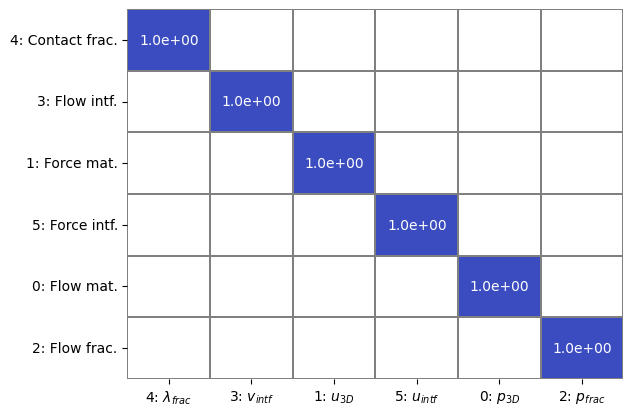

In [146]:
model.Q_perm.plot_max()

Solve  took: 0.0
True residual decrease: 2.0407646175805644e-11


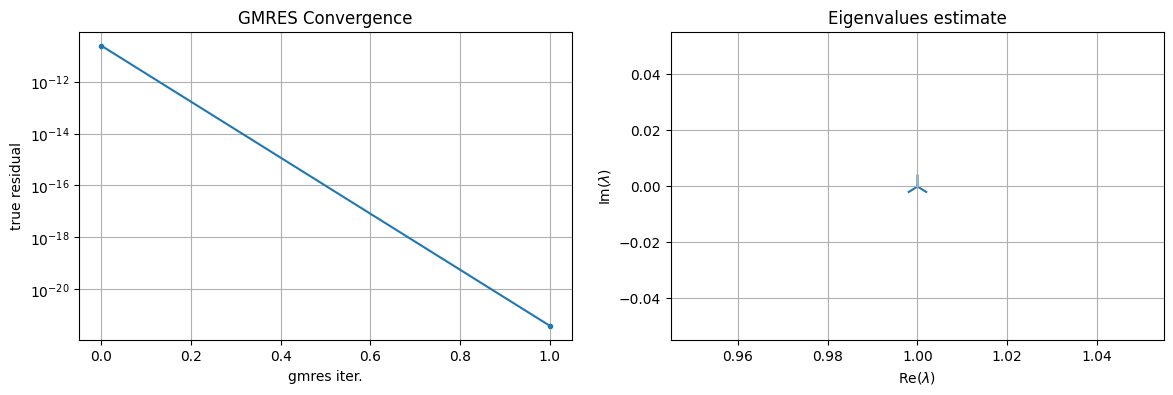

In [151]:
from block_matrix import SolveSchema, make_solver
from mat_utils import *
from preconditioner_mech import make_J44_inv_bdiag
from fixed_stress import make_fs, get_fixed_stress_stabilization, make_local_stab_15

schema = SolveSchema(
    # groups=[4],
    # solve=lambda bmat: inv_block_diag(mat=bmat[[4]].mat, nd=model.nd),
    # complement=SolveSchema(
        # groups=[3],
        # solve=lambda bmat: PetscILU(bmat[[3]].mat),
        # invertor=lambda bmat: extract_diag_inv(bmat[[3]].mat),
        # complement=SolveSchema(
            # groups=[1, 5],
            # solve=lambda bmat: PetscAMGMechanics(mat=bmat[[1, 5]].mat, dim=model.nd),
            # # invertor=lambda bmat: model._fixed_stress.mat,
            # # invertor=lambda bmat: get_fixed_stress_stabilization(model),
            # invertor=lambda bmat: make_local_stab_15(bmat=perm_mat, base=2, nd=1),
            # invertor_type="physical",
            # complement=SolveSchema(
                groups=[2],
                solve=lambda bmat: PetscAMGFlow(mat=bmat[[2]].mat),
            # ),
        # ),
    # ),
)

rhs_Q_global = model.Q_perm.global_rhs(model.rhs_Q)

bmat_reordered, preconditioner = make_solver(schema=schema, mat_orig=perm_mat)
solve_petsc(bmat_reordered.mat, preconditioner, rhs=bmat_reordered.local_rhs(rhs_Q_global), pc_side='right', tol=1e-5)

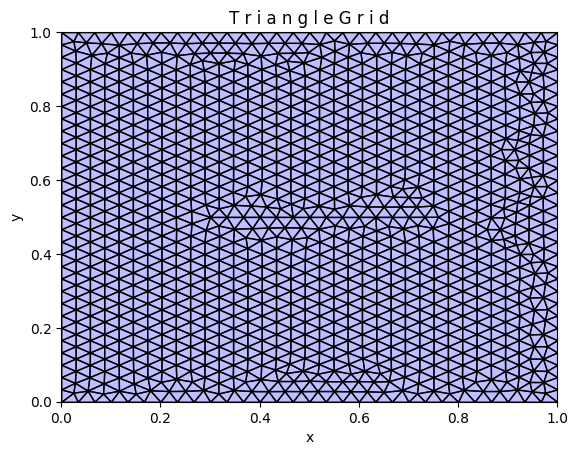

In [125]:
pp.plot_grid(
    model.mdg.subdomains(dim=2)[0],
    alpha=0.5,
    rgb=[0.5, 0.5, 1],
    plot_2d=True,
)